Overall, it's an amazing library! Only 2 complaints/challenges:
1. doesn't deal well with the hours being over 24. Not exactly sure how to fix it... 
2. mapping the routes doesn't give the "normal" route. It gives ALL variations meaning that flexible routes like the 5 are an absolute mess
3. schedule variations are still present (weekday-1)

- [Documentation](https://mrcagney.github.io/gtfs_kit_docs/index.html)
- [Github](https://github.com/mrcagney/gtfs_kit/tree/master)
- [more gtfs links](https://gtfs.org/resources/visualizations/)

# Imports/Installation

In [1]:
import gtfs_kit as gk
import pandas as pd 

In [5]:
path = "../data/google_transit"

# Using the Library


### Quality Assessment

In [6]:
# gk.list_feed(path)

In [7]:
# removing some rows with null start times
orig_feed = gk.read_feed(path, dist_units='mi')
feed = gk.miscellany.create_shapes(orig_feed, all_trips=True) 
feed = feed.clean()
feed.describe()

,indicator,value
0,agencies,[MTA New York City Transit]
1,timezone,America/New_York
2,start_date,20241215
3,end_date,20250117
4,num_routes,29
5,num_trips,20302
6,num_stops,1490
7,num_shapes,214
8,sample_date,20241219
9,num_routes_active_on_sample_date,29


In [8]:
# 214 shape variations!!
feed.trips['shape_id'].nunique()


214

In [10]:
# perfect except for num_stop_time_dists_missing
# gk.miscellany.assess_quality(feed)

In [11]:
gk.miscellany.summarize(feed)

,table,column,num_values,num_nonnull_values,num_unique_values,min_value,max_value
0,agency,agency_id,1,1,1,MTA_NYCT,MTA_NYCT
1,agency,agency_name,1,1,1,MTA New York City Transit,MTA New York City Transit
2,agency,agency_url,1,1,1,http://www.mta.info,http://www.mta.info
3,agency,agency_timezone,1,1,1,America/New_York,America/New_York
4,agency,agency_lang,1,1,1,en,en
5,agency,agency_phone,1,1,1,718-330-1234,718-330-1234
0,calendar,service_id,3,3,3,Saturday,Weekday
1,calendar,monday,3,3,2,0,1
2,calendar,tuesday,3,3,2,0,1
3,calendar,wednesday,3,3,2,0,1


In [12]:
week = feed.get_first_week()
# Getting 3 days so that we see the stats for each schedule type
dates = [week[4], week[5], week[6]]  # First Friday, Saturday & Sunday
dates

['20241220', '20241221', '20241222']

In [13]:
trip_stats = feed.compute_trip_stats()
trip_stats.head().T

,4,312,684,6,314
trip_id,AFA24GEN-1038-Sunday-00_007200_1..N03R,AFA24GEN-1039-Saturday-00_007200_1..N03R,AFA24GEN-1093-Weekday-00_007450_1..N03R,AFA24GEN-1038-Sunday-00_009200_1..N03R,AFA24GEN-1039-Saturday-00_009200_1..N03R
route_id,1,1,1,1,1
route_short_name,1,1,1,1,1
route_type,1,1,1,1,1
direction_id,0,0,0,0,0
shape_id,shape_006,shape_006,shape_006,shape_006,shape_006
stop_pattern_name,0-1,0-1,0-1,0-1,0-1
num_stops,38,38,38,38,38
start_time,01:12:00,01:12:00,01:14:30,01:32:00,01:32:00
end_time,02:10:30,02:10:30,02:12:30,02:30:30,02:30:30


In [14]:
fts = feed.compute_feed_time_series(trip_stats, dates, freq='3h')
fts

indicator,num_trip_ends,num_trip_starts,num_trips,service_distance,service_duration,service_speed
datetime,,,,,,
2024-12-20 00:00:00,299.0,409.0,408.0,5958.324571,392.833333,15.167564
2024-12-20 03:00:00,406.0,501.0,606.0,6091.940140,393.600000,15.477490
2024-12-20 06:00:00,1150.0,1463.0,1657.0,19597.897162,1238.100000,15.829010
2024-12-20 09:00:00,1411.0,1293.0,1804.0,20309.808330,1322.583333,15.356165
2024-12-20 12:00:00,1214.0,1213.0,1607.0,18561.539129,1205.883333,15.392483
2024-12-20 15:00:00,1378.0,1481.0,1871.0,21769.034622,1398.850000,15.562094
2024-12-20 18:00:00,1449.0,1312.0,1806.0,20698.849380,1311.916667,15.777564
2024-12-20 21:00:00,1007.0,812.0,1173.0,12553.083671,797.033333,15.749760
2024-12-21 00:00:00,306.0,414.0,413.0,6029.858431,391.650000,15.396038


## Plots of Service by Day Type

<Axes: xlabel='datetime'>

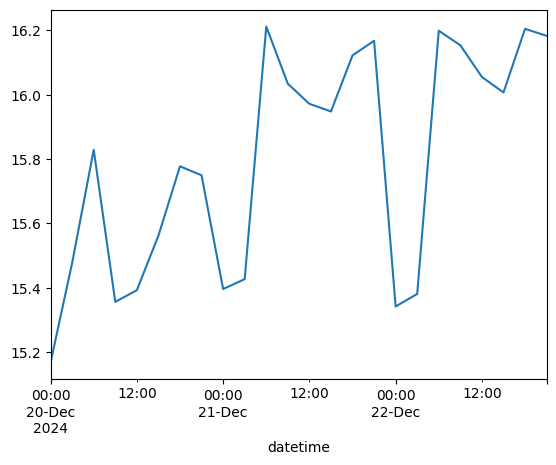

In [15]:
fts['service_speed'].plot()

<Axes: xlabel='datetime'>

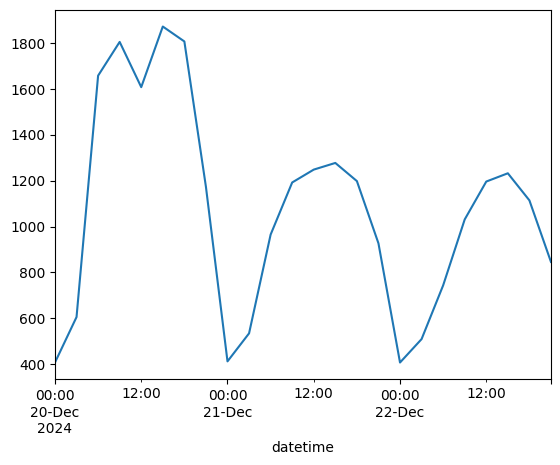

In [16]:
fts['num_trips'].plot()

## Route Timetables

In [93]:
# possible routes feed.routes['route_id'].unique()
route_id = 'L'
route_timetables = feed.build_route_timetable(route_id, dates)

In [94]:
example_trip_id = [route_timetables['trip_id'].iloc[0]]
route_timetables

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence,date
407695,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L29N,00:06:30,00:06:30,1,20241220
407696,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L28N,00:08:00,00:08:00,2,20241220
407697,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L27N,00:10:00,00:10:00,3,20241220
407698,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L26N,00:11:30,00:11:30,4,20241220
407699,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L25N,00:13:00,00:13:00,5,20241220
...,...,...,...,...,...,...,...,...,...,...,...
420582,L,BFA24GEN-L049-Weekday-00_148200_L..S01R,Weekday,Canarsie-Rockaway Pkwy,1,shape_170,L25S,25:16:30,25:16:30,20,20241220
420583,L,BFA24GEN-L049-Weekday-00_148200_L..S01R,Weekday,Canarsie-Rockaway Pkwy,1,shape_170,L26S,25:17:30,25:17:30,21,20241220
420584,L,BFA24GEN-L049-Weekday-00_148200_L..S01R,Weekday,Canarsie-Rockaway Pkwy,1,shape_170,L27S,25:19:00,25:19:00,22,20241220
420585,L,BFA24GEN-L049-Weekday-00_148200_L..S01R,Weekday,Canarsie-Rockaway Pkwy,1,shape_170,L28S,25:21:00,25:21:00,23,20241220


In [95]:
# Getting all Shape IDs in one file 
print(f"There are {route_timetables['shape_id'].nunique()} unique routes for the {route_id}")

There are 5 unique routes for the L


In [96]:
# getting one trip_id per shape_id
unique_shape_ids = route_timetables.drop_duplicates(subset=['route_id', 'service_id', 'shape_id'])
unique_shape_ids

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence,date
407695,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L29N,00:06:30,00:06:30,1,20241220
407791,L,BFA24GEN-L049-Weekday-00_005400_L..S01R,Weekday,Canarsie-Rockaway Pkwy,1,shape_170,L01S,00:54:00,00:54:00,1,20241220
408487,L,BFA24GEN-L049-Weekday-00_031950_L..N02R,Weekday,8 Av,0,shape_172,L28N,05:19:30,05:19:30,1,20241220
409581,L,BFA24GEN-L049-Weekday-00_045300_L..S05R,Weekday,Myrtle-Wyckoff Avs,1,shape_169,L01S,07:33:00,07:33:00,1,20241220
410003,L,BFA24GEN-L049-Weekday-00_048750_L..N05R,Weekday,8 Av,0,shape_171,L17N,08:07:30,08:07:30,1,20241220


In [103]:
# You can map routes with a trip ID
# some routes don't work b/c there's no shape ID in trips for them
unique_shape_id_example = [unique_shape_ids['trip_id'].iloc[4]]
plot = feed.map_trips(trip_ids=unique_shape_id_example)
plot

## Trip Stats

In [43]:
friday = dates = [week[4]]
trip_information_fri = feed.compute_route_stats(trip_stats, friday)
# I don't trust the peak information
trip_information_fri = trip_information_fri.drop(columns=['route_short_name', 'date', 'peak_num_trips', 'is_bidirectional'
                                                          ,'route_type', 'is_loop', 'peak_start_time', 'peak_end_time'])
trip_information_fri.round(3)

,route_id,num_trips,num_trip_starts,num_trip_ends,num_stop_patterns,start_time,end_time,max_headway,min_headway,mean_headway,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration
0,1,462,462,446,6,00:06:30,25:57:00,9.0,0.5,4.788,6634.179,433.617,15.300,14.360,0.939
1,2,324,324,301,7,00:19:00,27:40:30,13.0,0.0,7.114,7929.155,541.225,14.650,24.473,1.670
2,3,304,304,300,5,00:02:30,24:48:00,12.5,2.0,7.389,4750.101,314.542,15.102,15.625,1.035
3,4,370,370,351,21,00:05:30,27:06:00,11.5,0.0,6.132,7362.867,445.025,16.545,19.900,1.203
4,5,329,329,328,29,00:02:00,24:16:00,14.0,0.0,6.548,6337.060,391.058,16.205,19.262,1.189
5,6,439,439,419,6,00:07:00,26:06:00,10.5,0.0,4.977,5854.240,417.167,14.033,13.335,0.950
6,6X,113,113,113,2,06:09:00,21:15:00,10.5,3.0,7.274,1582.044,111.417,14.199,14.000,0.986
7,7,535,535,520,5,00:11:30,25:23:30,10.0,0.0,4.214,5206.509,341.867,15.230,9.732,0.639
8,7X,107,107,107,2,06:15:00,22:15:30,10.0,2.5,5.733,1052.467,65.875,15.977,9.836,0.616
9,A,375,375,351,22,00:11:30,27:49:00,16.0,0.0,6.609,9342.548,521.167,17.926,24.913,1.390


In [104]:
## this ignores trips that end after 24:00
# trip_information_fri.sort_values(by='num_trip_ends')
trip_information_fri.sort_values(by='service_speed')

,route_id,num_trips,num_trip_starts,num_trip_ends,num_stop_patterns,start_time,end_time,max_headway,min_headway,mean_headway,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration
15,FS,238,238,238,2,00:00:00,23:56:30,10.0,10.0,10.000000,321.837753,26.775000,12.020084,1.352259,0.112500
27,W,187,187,187,4,06:13:00,22:55:30,17.5,2.5,9.738095,1805.371737,138.275000,13.056386,9.654394,0.739439
25,R,303,303,297,9,00:15:00,25:17:00,11.5,1.5,7.465789,5676.352409,409.766667,13.852646,18.733836,1.352365
5,6,439,439,419,6,00:07:00,26:06:00,10.5,0.0,4.977352,5854.240445,417.166667,14.033337,13.335400,0.950266
6,6X,113,113,113,2,06:09:00,21:15:00,10.5,3.0,7.273684,1582.043788,111.416667,14.199346,14.000388,0.985988
22,M,292,292,290,6,00:00:00,24:18:00,11.0,4.5,7.889503,4150.625549,291.175000,14.254746,14.214471,0.997175
1,2,324,324,301,7,00:19:00,27:40:30,13.0,0.0,7.114428,7929.155259,541.225000,14.650386,24.472701,1.670448
20,J,287,287,276,9,00:08:30,25:47:30,13.5,0.0,7.843407,3646.688946,247.933333,14.708345,12.706233,0.863879
2,3,304,304,300,5,00:02:30,24:48:00,12.5,2.0,7.389175,4750.100715,314.541667,15.101658,15.625331,1.034677
12,D,296,296,276,10,00:08:30,27:14:00,12.0,1.5,7.645161,7149.960588,471.775000,15.155446,24.155272,1.593834


## Stop Patterns

In [105]:
#  trip_stats = feed.compute_trip_stats()
trip_stats.head()

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,stop_pattern_name,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
4,AFA24GEN-1038-Sunday-00_007200_1..N03R,1,1,1,0,shape_006,0-1,38,01:12:00,02:10:30,142N,101N,0,0.975000,14.511194,14.883276
312,AFA24GEN-1039-Saturday-00_007200_1..N03R,1,1,1,0,shape_006,0-1,38,01:12:00,02:10:30,142N,101N,0,0.975000,14.511194,14.883276
684,AFA24GEN-1093-Weekday-00_007450_1..N03R,1,1,1,0,shape_006,0-1,38,01:14:30,02:12:30,142N,101N,0,0.966667,14.511194,15.011580
6,AFA24GEN-1038-Sunday-00_009200_1..N03R,1,1,1,0,shape_006,0-1,38,01:32:00,02:30:30,142N,101N,0,0.975000,14.511194,14.883276
314,AFA24GEN-1039-Saturday-00_009200_1..N03R,1,1,1,0,shape_006,0-1,38,01:32:00,02:30:30,142N,101N,0,0.975000,14.511194,14.883276


In [106]:
# looking at the W
trip_stats[trip_stats['route_id']=='W']['stop_pattern_name'].unique()

array(['0-2', '0-1', '1-1', '1-2'], dtype=object)

In [107]:
# 1 route_type 
# 4 shape ids
trip_stats[trip_stats['route_id']=='W']['end_stop_id'].unique()

array(['R01N', 'R27S', 'N10S'], dtype=object)

In [108]:
trip_stats[(trip_stats['route_id']=='W')&(trip_stats['stop_pattern_name']=='0-2')]

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,stop_pattern_name,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
16275,BFA24GEN-N099-Weekday-00_042350_N..N70R,W,W,1,0,shape_185,0-2,44,07:03:30,08:28:00,N10N,R01N,0,1.408333,19.470612,13.825287
16537,BFA24GEN-N099-Weekday-00_099300_N..N70R,W,W,1,0,shape_185,0-2,44,16:33:00,18:01:00,N10N,R01N,0,1.466667,19.470612,13.275417


In [109]:
trip_stats[(trip_stats['route_id']=='J')]['num_stops'].unique()

array([30, 15, 16, 27, 23])

In [110]:
# the Z has 6 trips with different stopping patterns
trip_stats[(trip_stats['route_id']=='Z')].groupby('stop_pattern_name')['duration'].count()

stop_pattern_name
0-1    6
1-1    6
Name: duration, dtype: int64

In [123]:
unique_shape_ids1 = trip_stats[trip_stats['route_id']=='Z'].head(3)
unique_shape_id_example = unique_shape_ids1['trip_id'].iloc[0]

In [124]:
# weekday-2 trips happen in august to sept (20240812,20240902)
feed.trips[feed.trips['trip_id']==unique_shape_id_example]

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id
13413,Z,BFA24GEN-J055-Weekday-00_101550_J..N51R,Weekday,Jamaica Center-Parsons/Archer,0,shape_179


In [126]:
# weekday-1 trips happen in august to sept (20240903.20241214)
feed.trips[feed.trips['trip_id']==unique_shape_id_example]

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id
13413,Z,BFA24GEN-J055-Weekday-00_101550_J..N51R,Weekday,Jamaica Center-Parsons/Archer,0,shape_179


In [127]:
# J 
# 0-2 stop pattern, shape=186, local
plot = feed.map_trips(trip_ids=[unique_shape_id_example], show_stops=True, show_direction=True)
plot

In [98]:
# 0-2 stop pattern, shape=186, local
plot = feed.map_trips(trip_ids=['L0S4-J-1055-S02_101550_J..N51X001'], show_stops=True, show_direction=True)
plot

In [97]:
# 0-1 stop pattern, shape_183 and 153, express
plot = feed.map_trips(trip_ids=['BSP24GEN-J055-Weekday-00_101550_J..N51R'], show_stops=True, show_direction=True)
plot

## Mapping Routes

In [132]:
# will show different variations depending on the service variations
gk.routes.map_routes(feed, route_ids=['F'], show_stops=True)